In [17]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
#import corner
#import pandas as pd
#from arviz import plot_trace
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
plt.rcParams['figure.dpi'] = 100

## simulate image

In [4]:
from bepsf.image import PixelImage
from bepsf.image import super_to_obs
from bepsf.utils import gaussian_PSF


def simulate_image(Npix, Nsource, obserror_sigma, super_true, truepsf_func, **truepsfkws):
    image_obs = PixelImage(Npix, Npix)
    image_super = PixelImage(Npix, Npix, dx=1./super_true, dy=1./super_true)
    print ("observed image shape:", image_obs.shape)
    print ("supersampled image shape:", image_super.shape)
    
    np.random.seed(124)
    fluxes = 10**np.random.rand(Nsource)
    xcenters = np.random.rand(Nsource) * image_super.xmax
    ycenters = np.random.rand(Nsource) * image_super.ymax
    
    # assumes common noise, but should be \propto sqrt(flux) in reality?
    np.random.seed(123)
    image_err = np.ones(image_obs.shape) * obserror_sigma
    Zerr = image_err * np.random.randn(*image_obs.shape)
    image_super.Z = np.zeros_like(image_super.X)
    for f, x, y in zip(fluxes, xcenters, ycenters):
        #image_super.Z += gaussian_PSF(image_super.X, image_super.Y, f, x, y, source_sigma)*image_super.ds
        image_super.Z += truepsf_func(image_super.X, image_super.Y, f, x, y, **truepsfkws)*image_super.ds
    
    image_obs.Z = super_to_obs(image_super.Z, image_obs.X) + Zerr
    image_obs.Zerr = image_err
    
    return image_obs, image_super, fluxes, xcenters, ycenters

def elongated_psf(X, Y, norm, xc, yc, sigma, shift, frac):
    ret = gaussian_PSF(X, Y, norm*frac, xc+shift, yc+shift, sigma)
    ret += gaussian_PSF(X, Y, norm*(1.-frac), xc-shift, yc-shift, sigma)
    return ret

In [5]:
Npix = 30*3
Nsource = 10
supersample_true = 3.
source_sigma = 1.
source_half_extent = 3.5
obserr_sigma = 2e-3

In [6]:
# true PSF is a Gaussian 
#truepsffunc = gaussian_PSF
#truepsfkws = {"sigma": source_sigma}

In [7]:
# elongated PSF
truepsffunc = elongated_psf
truepsfkws = {"sigma": source_sigma, "shift": 0.5, "frac": 0.5}

In [8]:
image_obs, image_super, fluxes, xcenters, ycenters \
    = simulate_image(Npix, Nsource, obserr_sigma, supersample_true, truepsffunc, **truepsfkws)

observed image shape: (90, 90)
supersampled image shape: (270, 270)


## image mask

In [9]:
image_obs.define_mask(xcenters, ycenters, source_half_extent)

## initial guess for positions and fluxes

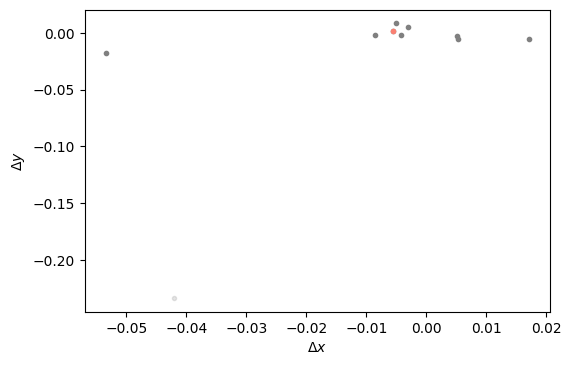

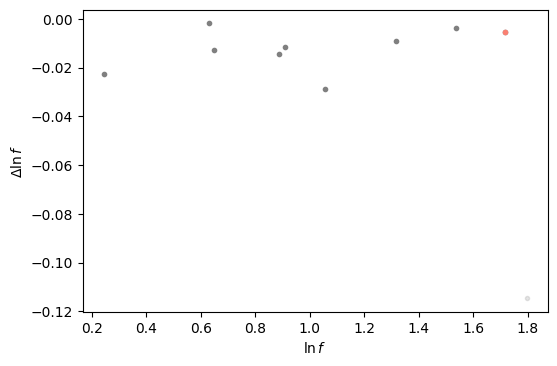

In [11]:
from bepsf.utils import choose_anchor

fap, xap, yap = image_obs.aperture_photometry(xcenters, ycenters, source_half_extent)
image_obs.lnfinit = np.log(np.array(fap))
image_obs.xinit = xap
image_obs.yinit = yap
image_obs.idx_anchor = choose_anchor(image_obs, xcenters, ycenters, lnfluxes=np.log(fluxes), 
                                     plot=True, mad_threshold=10)

### make sure that the anchor is an isolated source and is not around the edge

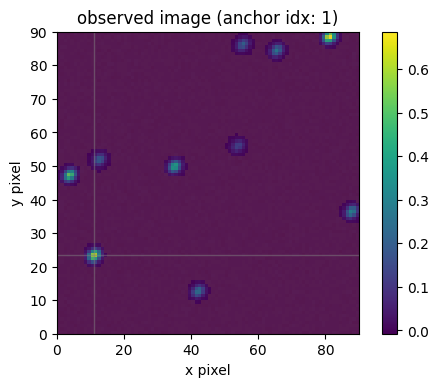

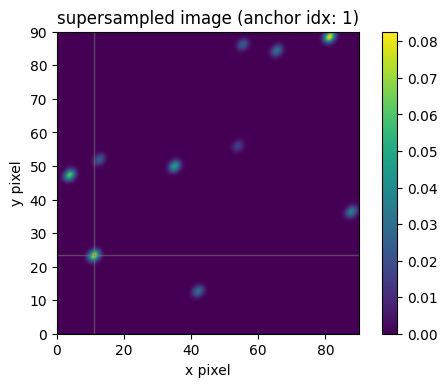

In [12]:
from bepsf.utils import check_anchor
check_anchor(image_obs, image_super=image_super)

## define grid PSF model

In [14]:
from bepsf.psfmodel import GridePSFModel

psf_full_extent = source_half_extent*2
dx, dy = 1./5., 1./5.
gridpsf = GridePSFModel(psf_full_extent, psf_full_extent, dx, dy)

PSF grid shape: (35, 35)
grid edge: x=[-3.500000, 3.500000], y=[-3.500000, 3.500000]
grid center: x=0.000000, y=0.000000


## optimization

In [15]:
#%%time
from bepsf.infer import optimize
from bepsf.utils import drop_anchor

res = optimize(gridpsf, image_obs, xyclim=[-source_half_extent, source_half_extent])
popt, state = res
popt = drop_anchor(popt, image_obs.idx_anchor)

# optimizing flux and position...
ScipyMinimizeInfo(fun_val=DeviceArray(-1603.43239689, dtype=float64), success=True, status=1, iter_num=16)

# optimizing GP parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-1632.56977844, dtype=float64), success=True, status=0, iter_num=6)

# optimizing all parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(-1632.58741763, dtype=float64), success=True, status=1, iter_num=9)


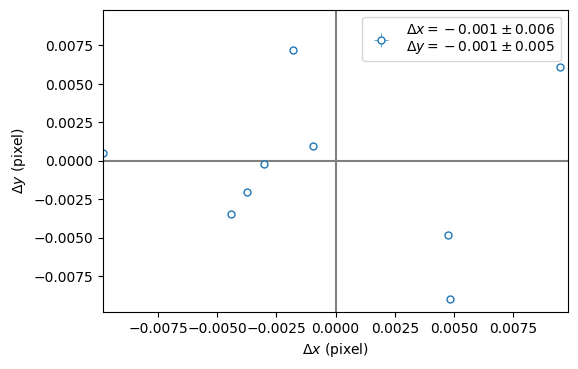

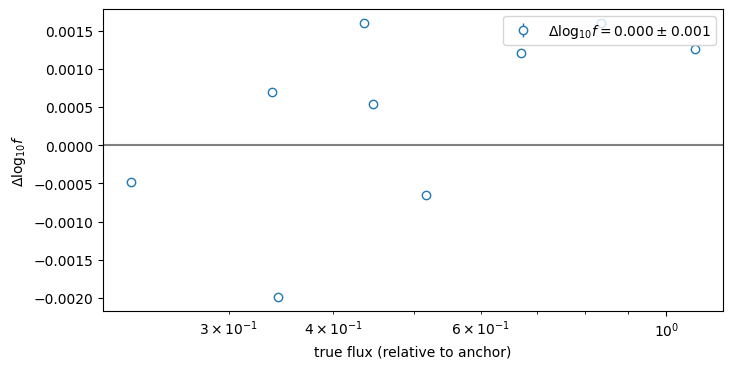

In [16]:
from bepsf.utils import check_solution
check_solution(image_obs, xcenters, ycenters, fluxes, p=popt)

In [18]:

mask1d = image_obs.mask1d
epsf1d_pred, _image1d_pred = gridpsf.predict_mean(popt['fluxes'], popt['xcenters'], popt['ycenters'], 
                            jnp.exp(popt['lnlenx']), jnp.exp(popt['lnleny']), jnp.exp(2*popt['lnamp']), jnp.exp(popt['lnmu']),
                            image_obs.X1d[~mask1d], image_obs.Y1d[~mask1d], image_obs.Z1d[~mask1d], image_obs.Zerr1d[~mask1d])
image1d_pred = np.zeros(image_obs.size)
image1d_pred[~mask1d] = _image1d_pred

In [20]:
from bepsf.utils import compute_epsf
ds = 0.05
x_offset = image_obs.xinit[image_obs.idx_anchor] - xcenters[image_obs.idx_anchor]
y_offset = image_obs.yinit[image_obs.idx_anchor] - ycenters[image_obs.idx_anchor]
finegrid = GridePSFModel(psf_full_extent, psf_full_extent, dx=ds, dy=ds)
epsf_pred = gridpsf.evaluate_ePSF(finegrid.X, finegrid.Y, x_offset, y_offset, epsf1d_pred)
true_epsf = compute_epsf(finegrid, truepsffunc, dict(**{"norm": 1., "xc": 0, "yc": 0}, **truepsfkws))

PSF grid shape: (141, 141)
grid edge: x=[-3.525000, 3.525000], y=[-3.525000, 3.525000]
grid center: x=0.000000, y=0.000000


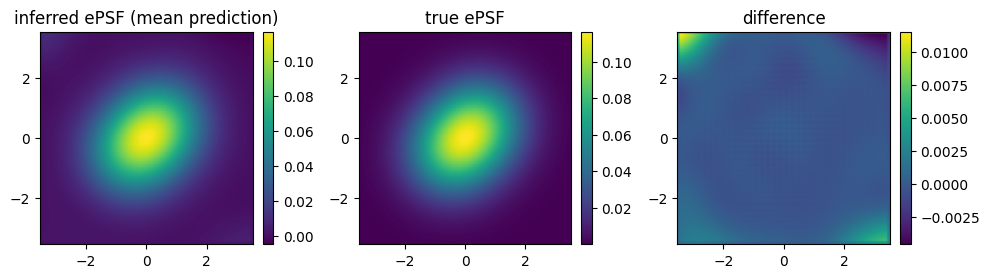

In [21]:
from bepsf.utils import check_ePSF_fit

check_ePSF_fit(finegrid, epsf_pred/np.sum(epsf_pred)/finegrid.ds, true_epsf/np.sum(true_epsf)/finegrid.ds)

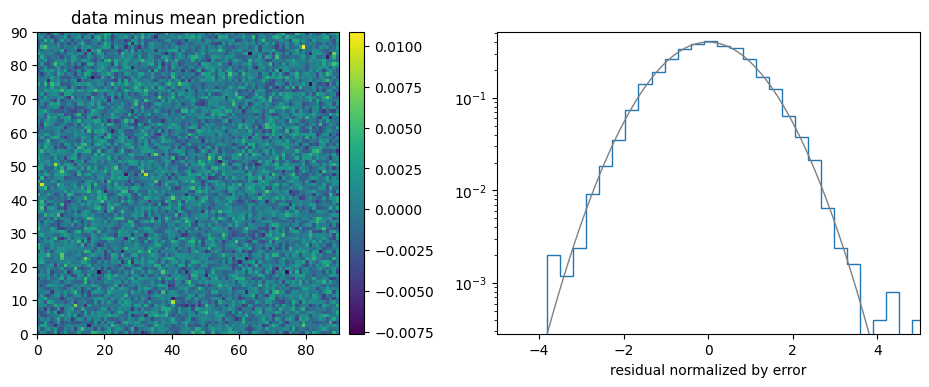

In [22]:
from bepsf.utils import check_image_fit
check_image_fit(image_obs, image1d_pred)

## run HMC

In [24]:
from bepsf.infer import run_hmc
mcmc = run_hmc(gridpsf, image_obs, popt)

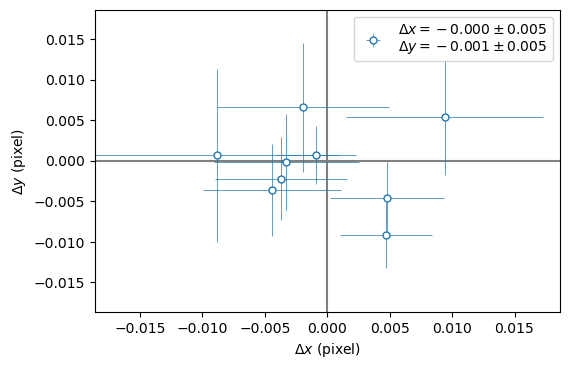

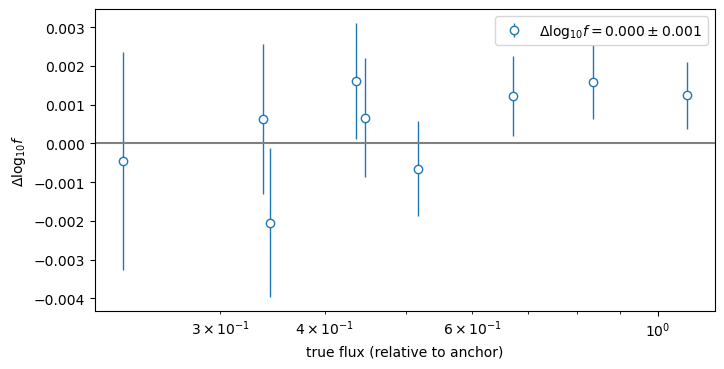

In [20]:
check_solution(image_obs, xcenters, ycenters, fluxes, samples=mcmc.get_samples())

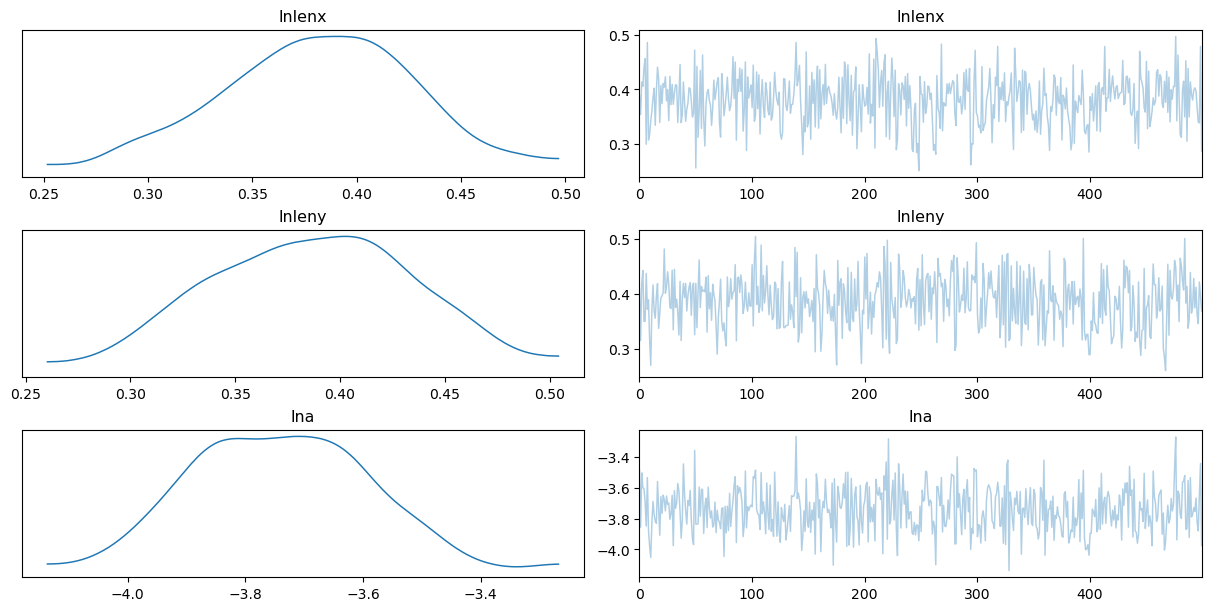

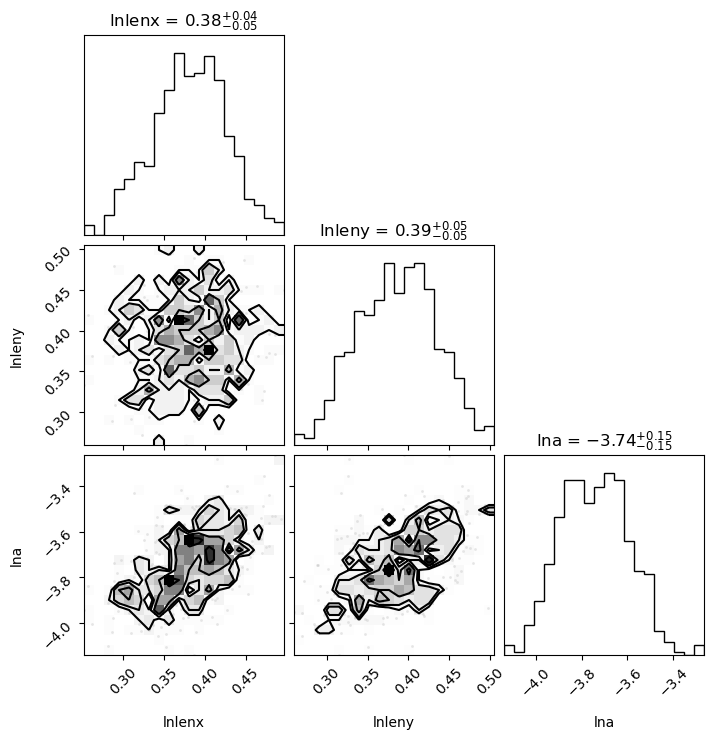

In [21]:
from bepsf.utils import check_mcmc_hyperparameters
check_mcmc_hyperparameters(mcmc)